In [1]:
# Herramientas
import os
from tqdm import tqdm
from pathlib import Path

# Manejo de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Lightning
import lightning as L

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Matplot estilo
plt.style.use('ggplot')

# Cargar datos
Cargados de [Kaggle](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?resource=download&select=mnist_train.csv)

In [2]:
data_path = Path(r"./data/")
print("Archivos en la carpeta data:")
print(os.listdir(data_path))

Archivos en la carpeta data:
['data.zip', 'mnist_test.csv', 'mnist_train.csv', 'sample_submission.csv']


## Cargar los .csv de entrenamiento y de prueba

In [3]:
train = pd.read_csv(data_path / "mnist_train.csv")
test = pd.read_csv(data_path / "mnist_test.csv")

In [4]:
print(f"Filas y columnas del set de entrenamiento: {train.shape}")

Filas y columnas del set de entrenamiento: (56000, 785)


In [5]:
# Imprimir una muestra del set de entrenamiento
train.sample(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
24833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
35793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Explorar el rango de valores en los datos

In [6]:
print(f"El valor mínimo de los datos: {np.min(train)}")
print(f"El valor máximo de los datos: {np.max(train)}")

El valor mínimo de los datos: 0.0
El valor máximo de los datos: 255.0


Explorar la cantidad de etiquetas por clase

In [7]:
train.label.value_counts().sort_index()

label
0    5522
1    6302
2    5592
3    5713
4    5459
5    5050
6    5501
7    5834
8    5460
9    5567
Name: count, dtype: int64

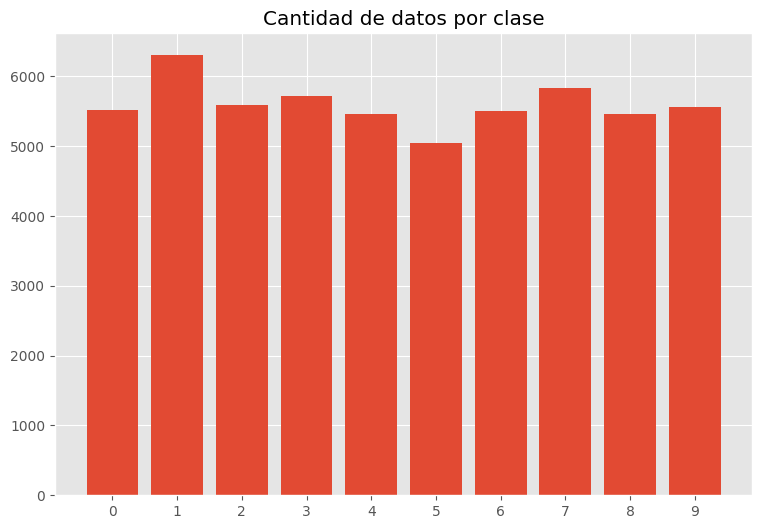

In [8]:
plt.figure(figsize=(9,6))
plt.bar(range(0, 10), train.label.value_counts().sort_index())
plt.xticks(range(0,10))
plt.title("Cantidad de datos por clase")
plt.show()

El conjunto de datos de entrenamiento está bastante balanceado

## Imágenes de prueba

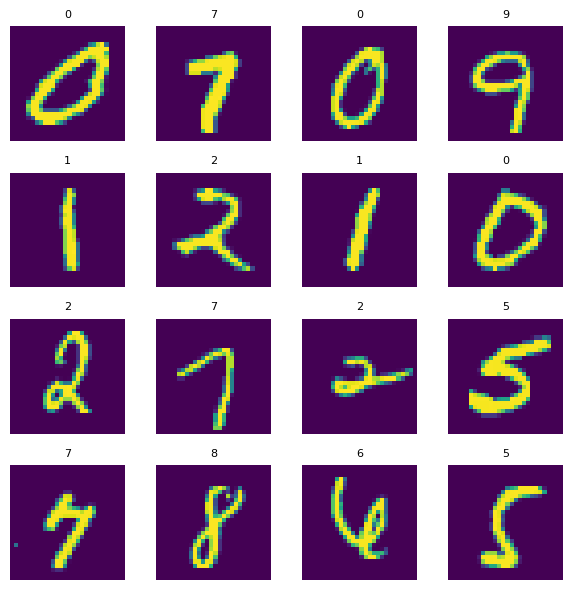

In [9]:
fig = plt.figure(figsize=(6,6))
rows, cols = 4, 4

classes = train["label"]
images = train.drop(columns="label")

for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(images.iloc[i].values.reshape((28,28)))
    ax.set_title(classes[i], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Dividir los datos en entrenamiento y prueba

In [10]:
from sklearn.model_selection import train_test_split

# Dividimos el set en 70% entrenamiento, 20% validación y 10% de prueba
train_split, valid_split = train_test_split(train, test_size=0.15, shuffle=True, random_state=42, stratify=train["label"])

train_split = train_split.reset_index(drop=True)
valid_split = valid_split.reset_index(drop=True)

In [11]:
print(f"Conjunto de datos de entrenamiento: {train_split.shape}")
print(f"Conjunto de datos de validación: {valid_split.shape}")

print(f"Conjunto de datos de prueba: {test.shape}")

Conjunto de datos de entrenamiento: (47600, 785)
Conjunto de datos de validación: (8400, 785)
Conjunto de datos de prueba: (14000, 784)


In [12]:
class Dataset(Dataset):
    """
    Toma un dataset, lo divide en imágenes, labels y lo convierte a tensores.
    """
    def __init__(self, dataset, trans=None):
        self.dataset = dataset
        self.labels = dataset['label']
        self.trans = trans

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset.iloc[idx,1:]
        if self.trans:
            img = self.trans(img).float()
        else:
            img = torch.tensor(img, dtype=torch.float)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return img, label

In [13]:
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToTensor(),
])

In [14]:
train_ds = Dataset(train_split, trans=None)
valid_ds = Dataset(valid_split, trans=None)

In [15]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size, num_workers=0)

In [16]:
images, labels = next(iter(train_loader))

In [17]:
images.shape, labels.shape

(torch.Size([128, 784]), torch.Size([128]))

# Modelo

In [18]:
import torch.nn as nn

class Module(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
    
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.metric = lambda y_hat, y: torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, batch):
        out = self.linear1(batch)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.metric(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc',self.metric(y_hat, y), prog_bar=True)

In [19]:
input_size = train.iloc[:,1:].shape[1] # El input size son nuestras columnas con dígitos
hidden_size = 128 # hidden size puede ser tomar el valor que querramos
classes = len(train.label.value_counts()) # classes son los dígitos a predecir

module = Module(input_size, hidden_size, classes)

In [20]:
module

Module(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
module = module.to(device)

In [23]:
torch.set_float32_matmul_precision('medium')

In [24]:
trainer = L.Trainer(
    accelerator=device,
    devices=1,
    max_epochs=1,
)

trainer.fit(module, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | linear1 | Linear           | 100 K 
1 | linear2 | Linear           | 1.3 K 
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 372/372 [00:49<00:00,  7.47it/s, v_num=7, train_acc=0.955, val_acc=0.930]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 372/372 [00:49<00:00,  7.47it/s, v_num=7, train_acc=0.955, val_acc=0.930]


In [25]:
test_split = test.copy()

In [26]:
test_split['label'] = 0 # como en test no tenemos una columna label creamos una y le asignamos un valor, 0 en este caso

In [27]:
test_ds = Dataset(test_split)
test_loader = DataLoader(test_ds, batch_size*2)

In [28]:
def inference(model, device, data_loader):
    """
    Toma un modelo, permite hacer inferencia con él, devuelve una lista con id y label para cada predicción.
    """
    submission = []
    model.to(device)
    # como estamos por hacer una inferencia, no necesitamos calcular gradientes, lo hacemos con torch.no_grad()
    with torch.no_grad():
        # ponemos al modelo en modo evaluación
        model.eval()
        # for loop para predecir todo el test_dataloader
        for images, _ in tqdm(data_loader):
            logits = model(images.to(device))
            preds = torch.exp(logits)
            top_p, top_class = preds.topk(1, dim=1)

            # appendeo de predicciones a submission con su correcpondiente id
            for prediction in top_class:
                submission.append(prediction.item())

    return submission

In [29]:
submission = inference(module, device, test_loader)

100%|██████████| 55/55 [00:09<00:00,  5.55it/s]


In [30]:
submission_df = pd.DataFrame(submission, columns=['label'])
submission_df

,label
0,7
1,3
2,1
3,1
4,2
...,...
13995,5
13996,2
13997,6
13998,2


In [31]:
# exportamos el submission dataframe como csv y nos aseguramos de quitar el índice
submission_df.to_csv('./submissions/submission_baseline_1.csv', index=False)